In [1]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.backend import ones_like
from keras.layers.recurrent import GRU
from keras.layers.core import Lambda
from keras.optimizers import adam
from keras.layers import Conv1D, Dense, Reshape, Concatenate, Flatten, Activation, Dropout,MaxPooling1D
from keras.models import Input, Model
from keras_self_attention import SeqSelfAttention
from keras_multi_head import MultiHeadAttention
import numpy as np
import os
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
tf.keras.backend.clear_session()  # For easy reset of notebook state.
config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)

/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/jiahao/translate/py35venv/lib/python3.5/site-pack

In [2]:
from keras import backend as K
from keras.layers import Layer ,Add
from keras.layers.core import Lambda


class adding_weight(Layer):

    def __init__(self, output_len, output_dim, **kwargs):
        self.output_len = output_len
        self.output_dim = output_dim
        super(adding_weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(15, self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(adding_weight, self).build(input_shape)
        
    def call(self, x):
        temp = Lambda(lambda y: K.dot(y, self.kernel))(x[1])
        temp = Lambda(lambda y: tf.expand_dims(y, 1))(temp)
        temp = Lambda(lambda y: tf.tile(y, multiples=[1, self.output_len, 1]))(temp)
        temp = Lambda(lambda y: tf.multiply(x[0], y))(temp)
        return Add()([x[0], temp])

    def compute_output_shape(self, input_shape):
        return (None, self.output_len, self.output_dim)

def local_context_learning(path_length, input_length, input_dim, output_dim, hidden_dim, filters_num, kernel_val,
                           learning_rate, drop_rate):
    basic_data_input = Input(shape=(path_length, input_length, input_dim))

    basic_input = Reshape((path_length, input_length * input_dim))(basic_data_input)

    label_data_input = Input(shape=(path_length,))

    weighted_input = adding_weight(path_length, input_length * input_dim)([basic_input, label_data_input])

    GRU_layer = GRU(units=hidden_dim, return_sequences=True)
    rnn_output = GRU_layer(weighted_input)
    Self_1 = SeqSelfAttention(attention_activation='sigmoid')
    rnn_att = Self_1(rnn_output)
    CNN_layer_1 = Conv1D(filters=filters_num, kernel_size=kernel_val, padding="same")
    cnn_output = CNN_layer_1(weighted_input)
    Dense_1 = Dense(hidden_dim)
    cnn_output_reformat = Dense_1(cnn_output)
    Self_2 = SeqSelfAttention(attention_activation='sigmoid')
    cnn_att = Self_2(cnn_output_reformat)
    Conca_1 = Concatenate(axis=1)
    new_value = Conca_1([rnn_att, cnn_att])
    new_keys = Lambda(lambda x: ones_like(x))(new_value)
    Multi_1 = MultiHeadAttention(head_num=2)
    new_result = Multi_1([weighted_input, new_keys, new_value])
    result = Flatten()(new_result)
    Drop_1 = Dropout(rate=drop_rate)
    result_fix = Drop_1(result)
    Dense_2 = Dense(output_dim)
    method_vector = Dense_2(result_fix)
    method_vector = Reshape((-1, 128))(method_vector)

    CNN_layer_2 = Conv1D(filters=filters_num, kernel_size=kernel_val, padding="same")
    cnn_output_for_classification = CNN_layer_2(method_vector)
    Pool_1 = MaxPooling1D(pool_size=2, padding='same')
    pooling_output = Pool_1(cnn_output_for_classification)
    output_classification = Flatten()(pooling_output)
    Drop_2 = Dropout(rate=drop_rate)
    output_classification_fix = Drop_2(output_classification)
    Dense_3 = Dense(32, activation='relu')
    output_classification_fix = Dense_3(output_classification_fix)
    Dense_4 = Dense(16, activation='relu')
    output_classification_fix = Dense_4(output_classification_fix)
    Dense_5 = Dense(1)
    fixed_output_classification = Dense_5(output_classification_fix)
    Active_1 = Activation(activation='sigmoid')
    stand_output = Active_1(fixed_output_classification)
    model = Model([basic_data_input, label_data_input], stand_output)
    ada = adam(lr=learning_rate)
    model.compile(optimizer=ada, loss='binary_crossentropy', metrics=['accuracy'])

    
    New_input  = Input(shape=(path_length, input_length, input_dim))
    New_input_ = Reshape((path_length, input_length * input_dim))(New_input)
    new_test_1 = GRU_layer(New_input_)
    new_test_2 = Self_1(new_test_1)
    new_test_3 = CNN_layer_1(New_input_)
    new_test_4 = Dense_1(new_test_3)
    new_test_5 = Self_2(new_test_4)
    new_test_6 = Conca_1([new_test_2, new_test_5])
    new_test_7 = Lambda(lambda x: ones_like(x))(new_test_6)
    new_test_8 = Multi_1([New_input_, new_test_7, new_test_6])
    new_test_9 = Flatten()(new_test_8)
    new_test_10 = Drop_1(new_test_9)
    new_test_11 = Dense_2(new_test_10)
    new_test_12 = Reshape((-1, 128))(new_test_11)
    new_test_13 = CNN_layer_2(new_test_12)
    new_test_14 = Pool_1(new_test_13)
    new_test_15 = Flatten()(new_test_14)
    new_test_16 = Drop_2(new_test_15)
    new_test_17 = Dense_3(new_test_16)
    new_test_18 = Dense_4(new_test_17)
    new_test_19 = Dense_5(new_test_18)
    new_test_20 = Active_1(new_test_19)
    model_test = Model(New_input, new_test_20)
    return model, model_test

In [3]:
model_local,model_local_test = local_context_learning(15, 20, 128, 128, 128, 64, 3, 0.0001, 0.5)
model_local.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 20, 128)  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 15, 2560)     0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
adding_weight_1 (adding_weight) (None, 15, 2560)     38400       reshape_1[0][0]                

In [4]:
def getting_data(file_path, print_text):
    print("Loading " + print_text + " Data...")
    data = np.load(file_path,allow_pickle = True)
    print("Done")
    return data

In [5]:
input_data = getting_data("./data/local_train_input_combine.npy", "Input")
label_data = getting_data("./data/local_train_label_combine.npy", "Label")
output_data = getting_data("./data/local_train_output_combine.npy", "Output")
label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Label Data...
Done
Loading Output Data...
Done


In [6]:
label_data.shape

(7151, 15)

In [7]:
v_input_data = getting_data("./data/local_val_input_combine.npy", "Input")
v_label_data = getting_data("./data/local_val_label_combine.npy", "Label")
v_output_data = getting_data("./data/local_val_output_combine.npy", "Output")
v_label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Label Data...
Done
Loading Output Data...
Done


In [8]:
v_label_data.shape

(2388, 15)

In [9]:
print("Training Local Context Model...")
model_local.fit([input_data,label_data], output_data, batch_size=256, epochs=100,validation_data=([v_input_data,v_label_data], v_output_data))

Training Local Context Model...

Train on 7151 samples, validate on 2388 samples
Epoch 1/100
7151/7151 [==============================] - 20s 3ms/step - loss: 0.6914 - accuracy: 0.5363 - val_loss: 0.6879 - val_accuracy: 0.5402
Epoch 2/100
7151/7151 [==============================] - 16s 2ms/step - loss: 0.6846 - accuracy: 0.5718 - val_loss: 0.6685 - val_accuracy: 0.6273
Epoch 3/100
7151/7151 [==============================] - 15s 2ms/step - loss: 0.6602 - accuracy: 0.6212 - val_loss: 0.6541 - val_accuracy: 0.6231
Epoch 4/100
7151/7151 [==============================] - 15s 2ms/step - loss: 0.6367 - accuracy: 0.6539 - val_loss: 0.6387 - val_accuracy: 0.6608
Epoch 5/100
7151/7151 [==============================] - 15s 2ms/step - loss: 0.6164 - accuracy: 0.6768 - val_loss: 0.6022 - val_accuracy: 0.6868
Epoch 6/100
7151/7151 [==============================] - 15s 2ms/step - loss: 0.5906 - accuracy: 0.6950 - val_loss: 0.5862 - val_accuracy: 0.6855
Epoch 7/100
7151/7151 [====================

Epoch 55/100
7151/7151 [==============================] - 12s 2ms/step - loss: 0.2321 - accuracy: 0.9034 - val_loss: 0.7255 - val_accuracy: 0.7638
Epoch 56/100
7151/7151 [==============================] - 12s 2ms/step - loss: 0.2710 - accuracy: 0.8793 - val_loss: 0.6521 - val_accuracy: 0.7864
Epoch 57/100
7151/7151 [==============================] - 12s 2ms/step - loss: 0.2506 - accuracy: 0.8915 - val_loss: 0.6734 - val_accuracy: 0.7906
Epoch 58/100
7151/7151 [==============================] - 12s 2ms/step - loss: 0.2700 - accuracy: 0.8792 - val_loss: 0.6754 - val_accuracy: 0.7705
Epoch 59/100
7151/7151 [==============================] - 12s 2ms/step - loss: 0.2231 - accuracy: 0.9080 - val_loss: 0.7105 - val_accuracy: 0.7642
Epoch 60/100
7151/7151 [==============================] - 12s 2ms/step - loss: 0.2291 - accuracy: 0.9016 - val_loss: 0.7418 - val_accuracy: 0.7848
Epoch 61/100
7151/7151 [==============================] - 12s 2ms/step - loss: 0.2316 - accuracy: 0.9018 - val_loss: 0

In [10]:
model_local.save('model_combine_adding_weight_train.h5')
model_local_test.save('model_combine_adding_weight_test.h5')

In [11]:
t_input_data = getting_data("./data/local_test_input_combine.npy", "Input")
t_label_data = getting_data("./data/local_test_label_combine.npy", "Label")
t_output_data = getting_data("./data/local_test_output_combine.npy", "Output")
t_label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Label Data...
Done
Loading Output Data...
Done


In [12]:
t_label_data.shape

(2365, 15)

In [13]:
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# using input lable 0s when testing

In [14]:
y_predict = model_local_test.predict(t_input_data)

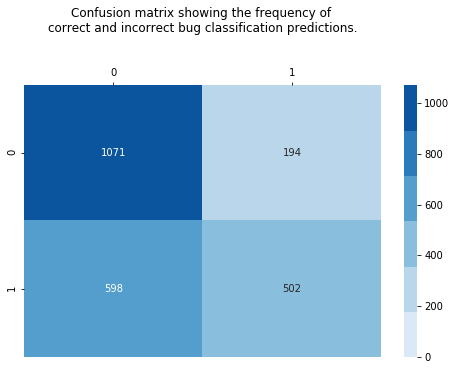

In [15]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(t_output_data, np.rint(y_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [16]:
tn, fp, fn, tp = metrics.confusion_matrix(
    t_output_data.astype(int), 
    np.rint(y_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)
r = tp/(tp+fn)
p = tp/(tp+fp)
f = (2*p*r)/(p+r)
acc = (tp+tn)/(tp+fp+fn+tn)

In [17]:
print("fpr_nn",fpr_nn)
print("fnr_nn",fnr_nn)
print("r",r)
print("p",p)
print("f",f)
print("acc",acc)

fpr_nn 0.27873563218390807
fnr_nn 0.35829838226482924
r 0.45636363636363636
p 0.7212643678160919
f 0.5590200445434298
acc 0.6651162790697674


In [18]:
from sklearn.metrics import  auc, roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(t_output_data, y_predict)
precision, recall, thresholds = precision_recall_curve(t_output_data, y_predict)

In [19]:
import matplotlib.pyplot as plt

auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(t_output_data, y_predict)
pr_auc = auc(recall, precision)
f1 = f1_score(t_output_data, np.rint(y_predict))
mcc = matthews_corrcoef(t_output_data, np.rint(y_predict))

In [20]:
print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.702
ROC AUC: 0.701
MCC: 0.332
F1: 0.559


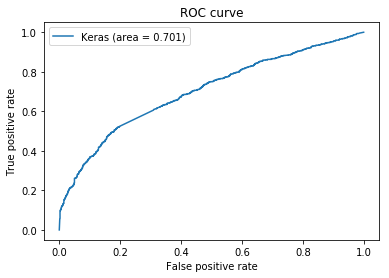

In [21]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Find the best threshold for balanced testing

In [22]:
best_f1 = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if f>best_f1:
        best_f1 = f
        print(r,p,f,acc,predict)

0.5236363636363637 0.6973365617433414 0.5981308411214954 0.6727272727272727 [0.2397123]
0.85 0.53034600113443 0.6531610199091862 0.5801268498942918 [0.00583699]
0.8590909090909091 0.52734375 0.6535269709543569 0.5763213530655391 [0.00458506]
0.8590909090909091 0.5276381909547738 0.6537530266343825 0.5767441860465117 [0.00460258]


In [24]:
best_r = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if r>best_r:
        best_r = r
        print(r,p,f,acc,predict)

0.5236363636363637 0.6973365617433414 0.5981308411214954 0.6727272727272727 [0.2397123]
0.85 0.53034600113443 0.6531610199091862 0.5801268498942918 [0.00583699]
0.8972727272727272 0.5022900763358779 0.6440456769983687 0.5386892177589852 [0.0008738]
0.9954545454545455 0.46754910333048677 0.6362579895409646 0.47061310782241017 [0.]


In [25]:
best_a = 0
for predict in y_predict:
    predict_after_threshold = np.int64(y_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if acc>best_a:
        best_a = acc
        print(r,p,f,acc,predict)

0.5236363636363637 0.6973365617433414 0.5981308411214954 0.6727272727272727 [0.2397123]
0.5181818181818182 0.7019704433497537 0.5962343096234309 0.6735729386892177 [0.26164377]
0.52 0.701840490797546 0.5973890339425588 0.6739957716701903 [0.25489086]
0.52 0.7027027027027027 0.5977011494252874 0.6744186046511628 [0.25672895]


# imbalance testing

In [23]:
im_t_input_data = getting_data("./data/local_im_test_input_combine.npy", "Input")
im_t_label_data = getting_data("./data/local_im_test_label_combine.npy", "Lable")
im_t_output_data = getting_data("./data/local_im_test_output_combine.npy", "Output")
im_t_label_data.shape=(-1,15)

Loading Input Data...
Done
Loading Lable Data...
Done
Loading Output Data...
Done


In [26]:
im_t_label_data.shape

(12491, 15)

In [27]:
im_t_input_data.shape

(12491, 15, 20, 128)

# using input lable 0s when im_testing

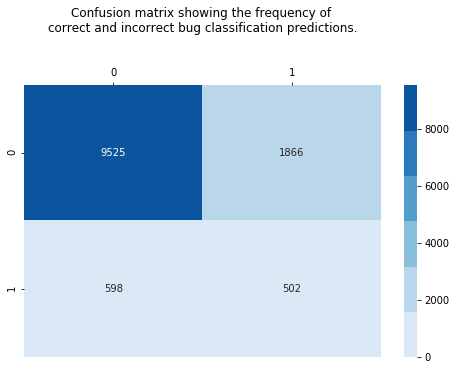

In [28]:
y_im_predict = model_local_test.predict(im_t_input_data)

confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(im_t_output_data, np.rint(y_im_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [29]:
tn, fp, fn, tp = metrics.confusion_matrix(
    im_t_output_data.astype(int), 
    np.rint(y_im_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)
r = tp/(tp+fn)
p = tp/(tp+fp)
f = (2*p*r)/(p+r)
acc = (tp+tn)/(tp+fp+fn+tn)
print("fpr_nn",fpr_nn)
print("fnr_nn",fnr_nn)
print("r",r)
print("p",p)
print("f",f)
print("acc",acc)

fpr_nn 0.7880067567567568
fnr_nn 0.05907339721426454
r 0.45636363636363636
p 0.21199324324324326
f 0.2895040369088812
acc 0.8027379713393643


# Find the best threshold for imbalanced testing

In [30]:
best_f1 = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if f>best_f1:
        best_f1 = f
        print(r,p,f,acc,predict)

0.48 0.20386100386100386 0.2861788617886179 0.7891281722840445 [0.39346638]
0.47454545454545455 0.20640569395017794 0.287682557178286 0.7930509967176367 [0.41799238]
0.3654545454545455 0.2503113325031133 0.29711751662971175 0.8477303658634217 [0.85429263]
0.33 0.2733433734939759 0.299011532125206 0.863741894163798 [0.925398]
0.33545454545454545 0.2707263389581805 0.29963459196102316 0.8619005684092547 [0.91799676]
0.33454545454545453 0.2713864306784661 0.2996742671009772 0.862300856616764 [0.91932464]
0.3336363636363636 0.2720533728687917 0.2997141690485913 0.8627011448242735 [0.92141795]
0.33454545454545453 0.27158671586715866 0.2997963340122199 0.8623809142582659 [0.91994226]
0.3336363636363636 0.27245731254639943 0.29995913363302 0.8628612601072773 [0.9216329]


In [31]:
best_a = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if acc>best_a:
        best_a = acc
        print(r,p,f,acc,predict)

0.48 0.20386100386100386 0.2861788617886179 0.7891281722840445 [0.39346638]
0.1318181818181818 0.48986486486486486 0.20773638968481373 0.9114562484989193 [0.99953115]
0.06272727272727273 0.7263157894736842 0.11548117154811716 0.9153790729325114 [0.9999997]
0.09090909090909091 0.6410256410256411 0.1592356687898089 0.9154591305740133 [0.99997324]
0.09545454545454546 0.6441717791411042 0.166270783847981 0.9156993034985189 [0.99996436]
0.06909090909090909 0.7307692307692307 0.12624584717607973 0.9157793611400208 [0.999999]
0.07272727272727272 0.7207207207207207 0.13212221304706853 0.9158594187815227 [0.9999987]
0.07454545454545454 0.7256637168141593 0.13520197856553998 0.9160195340645264 [0.99999845]


In [32]:
best_r = 0
for predict in y_im_predict:
    predict_after_threshold = np.int64(y_im_predict>predict)
    tn, fp, fn, tp = metrics.confusion_matrix(
        im_t_output_data.astype(int), 
        predict_after_threshold
    ).flatten().tolist()
    try:
        fpr_nn = fp/(fp+tp)
        fnr_nn = fn/(fn+tn)
        r = tp/(tp+fn)
        p = tp/(tp+fp)
        f = (2*p*r)/(p+r)
        acc = (tp+tn)/(tp+fp+fn+tn)
    except:
        continue
    if r>best_r:
        best_r = r
        print(r,p,f,acc,predict)

0.48 0.20386100386100386 0.2861788617886179 0.7891281722840445 [0.39346638]
0.71 0.1273231170524943 0.21592479955764446 0.545913057401329 [0.06586337]
0.8590909090909091 0.10637100405222873 0.1893028846153846 0.3520134496837723 [0.00438213]
0.9172727272727272 0.09617767610332666 0.1741005952894487 0.2336081979024898 [0.00036618]
0.9818181818181818 0.08943358728055648 0.1639344262295082 0.118085021215275 [1.3709068e-06]
0.9881818181818182 0.08901809843583654 0.1633235669746826 0.10839804659354735 [2.682209e-07]
0.9918181818181818 0.0888943208669437 0.16316458535855832 0.10407493395244576 [1.1920929e-07]
0.9927272727272727 0.08877327046581579 0.16297291246921872 0.10199343527339684 [8.940697e-08]
0.9954545454545455 0.08861374119932022 0.16274058111020287 0.09799055319830277 [0.]
